In [1]:
!nvidia-smi

Wed Jan 15 08:30:43 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   38C    P0             26W /  250W |       0MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# 1. Download dataset

In [2]:
!pip install gdown torchinfo --quiet

In [3]:
import sys
sys.path.append('/content/Traffic-Vehicle-Detection-in-Normal-and-Adverse-Environmental-Conditions')

In [4]:
import requests
from pathlib import Path

if Path("dataloader.py").is_file():
  print("File dataloader.py exists")
else:
  request = requests.get(url="https://raw.githubusercontent.com/nguyenquan132/Traffic-Vehicle-Detection-in-Normal-and-Adverse-Environmental-Conditions/refs/heads/master/dataloader.py")
  with open("dataloader.py", 'wb') as f:
    f.write(request.content)

In [5]:
if Path("evaluate.py").is_file():
  print("File evaluate.py exists")
else:
  request = requests.get(url="https://raw.githubusercontent.com/nguyenquan132/Traffic-Vehicle-Detection-in-Normal-and-Adverse-Environmental-Conditions/refs/heads/master/evaluate.py")
  with open("evaluate.py", 'wb') as f:
    f.write(request.content)

In [6]:
if Path("function.py").is_file():
  print("File function.py exists")
else:
  request = requests.get(url="https://raw.githubusercontent.com/nguyenquan132/Traffic-Vehicle-Detection-in-Normal-and-Adverse-Environmental-Conditions/refs/heads/master/function.py")
  with open("function.py", 'wb') as f:
    f.write(request.content)

In [7]:
if Path("train.py").is_file():
  print("File train.py exists")
else:
  request = requests.get(url="https://raw.githubusercontent.com/nguyenquan132/Traffic-Vehicle-Detection-in-Normal-and-Adverse-Environmental-Conditions/refs/heads/master/faster_rcnn/train.py")
  with open("train.py", 'wb') as f:
    f.write(request.content)

# 2. Load dataset from dataloader.py

In [8]:
from dataloader import TrafficVehicle
import cv2
import matplotlib.pyplot as plt
import torch
from function import collate_fn, loss_mAP_curve, precision_recall_curve, confidence_metric
from torch.utils.data import DataLoader, SubsetRandomSampler
import albumentations as A
from evaluate import evaluate
from train import train_step
import numpy as np
from torchvision import models
from torch import nn
from albumentations.pytorch import ToTensorV2
from tqdm.auto import tqdm
from torchmetrics.detection.mean_ap import MeanAveragePrecision

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 2.0.0 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


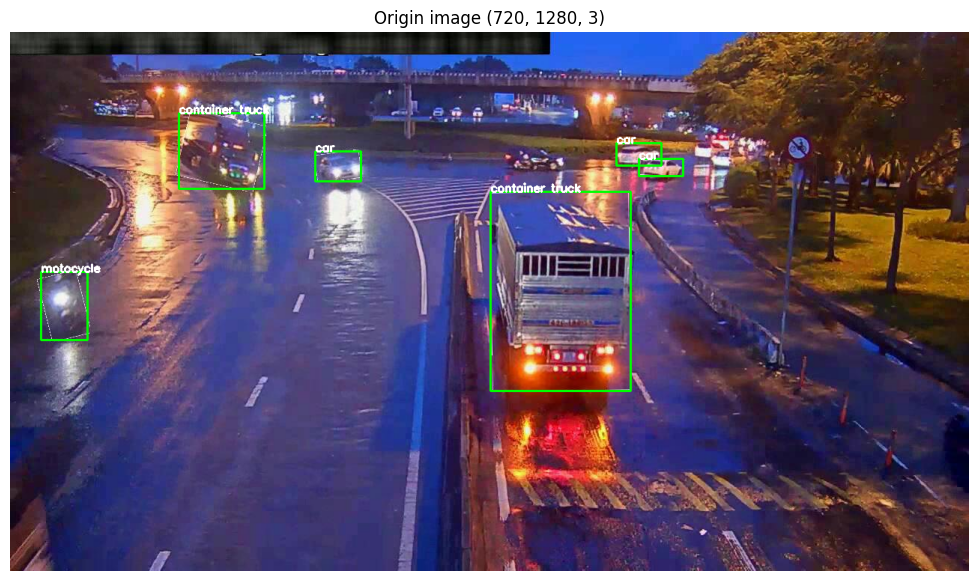

In [9]:
data = TrafficVehicle(folder="/kaggle/input/dataset-vehicle/data/data/train", transform_box_type="corner")
origin_image = data[5520][0]

plt.figure(figsize=(15, 7))
labels, boxes = data[5520][1]['labels'], torch.Tensor.numpy(data[5520][1]['boxes'])
frame = origin_image.copy()

for box, label in zip(boxes, labels):
    xmin, ymin, xmax, ymax = int(box[0]), int(box[1]), int(box[2]), int(box[3])
    annotated_image = cv2.rectangle(frame, (xmin, ymin), (xmax, ymax), color=(0, 255, 0), thickness=2)
    label_name = data.class_name[int(label)]
    annotated_image = cv2.putText(annotated_image, label_name, (xmin, ymin), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.5,
                                color=(255, 255, 255), thickness=2)

plt.imshow(annotated_image)
plt.title(f"Origin image {origin_image.shape}")
plt.axis('off')
plt.show()

In [10]:
train_transform = A.Compose([
    A.Resize(300, 300),
    A.GaussianBlur(blur_limit=(3, 7), p=0.5),
    A.RandomBrightnessContrast(brightness_limit=(-0.3, -0.3), contrast_limit=(0.2, 0.2), p=0.5),
    A.HueSaturationValue(hue_shift_limit=(1, 1), p=0.5),
    A.Sharpen(p=0.5),
    A.ToFloat(max_value=255.0),
    ToTensorV2(p=1.0)
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels'], min_visibility=0.3))

val_transform = A.Compose([
    A.Resize(300, 300),
    A.ToFloat(max_value=255.0),
    ToTensorV2(p=1.0)
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))

train_data = TrafficVehicle(folder="/kaggle/input/dataset-vehicle/data/data/train", transforms=train_transform, 
                            transform_box_type="corner")
val_data = TrafficVehicle(folder="/kaggle/input/dataset-vehicle/data/data/val", transforms=val_transform, 
                          transform_box_type="corner")

Image after applying data augmentation



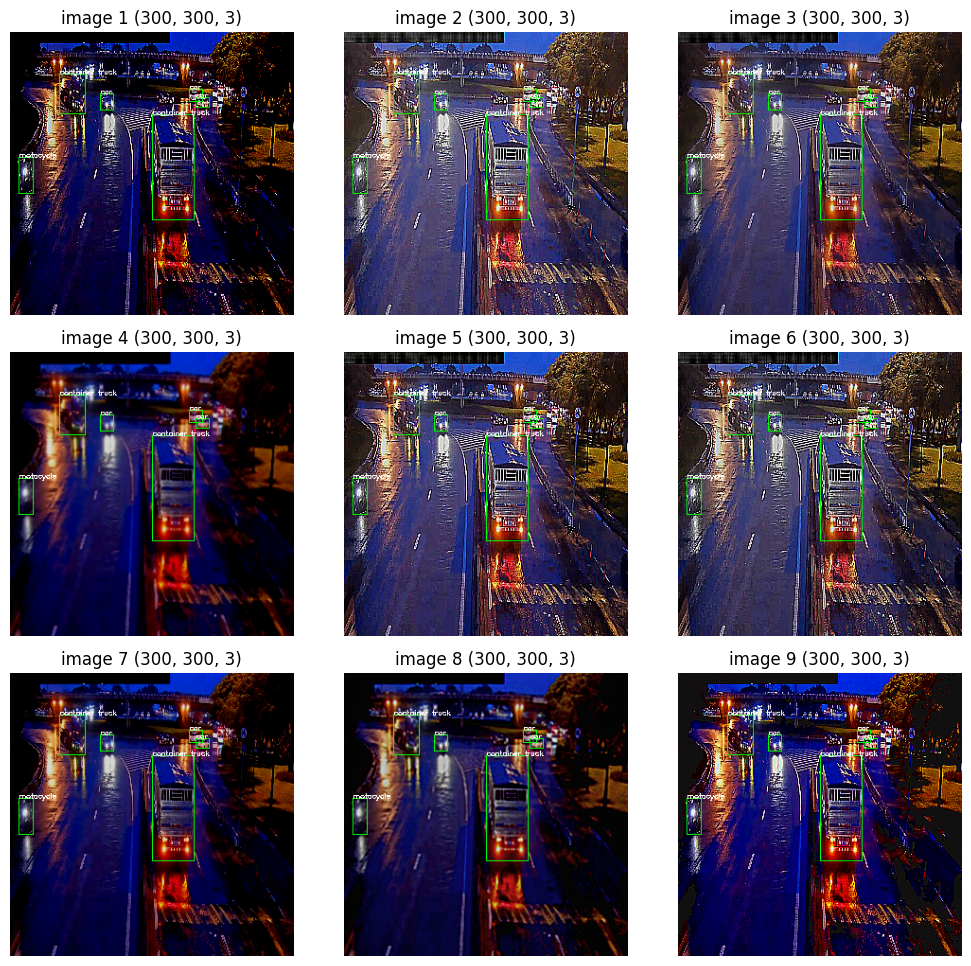

In [11]:
print("Image after applying data augmentation\n")
plt.figure(figsize=(10, 10))
for i in range(1, 10):
    img = torch.Tensor.numpy(train_data[5520][0].permute(1, 2, 0))

    height, width = origin_image.shape[:2]
    labels, boxes = train_data[5520][1]['labels'], torch.Tensor.numpy(train_data[5520][1]['boxes'])
    frame = img.copy()

    for box, label in zip(boxes, labels):
        xmin, ymin, xmax, ymax = int(box[0]), int(box[1]), int(box[2]), int(box[3])
        annotated_img = cv2.rectangle(frame, (xmin, ymin), (xmax, ymax), color=(0, 255, 0), thickness=1)
        label_name = train_data.class_name[int(label)]
        annotated_img = cv2.putText(annotated_img, label_name, (xmin, ymin), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.25,
                                    color=(255, 255, 255), thickness=1)

    plt.subplot(3, 3, i)
    plt.imshow(annotated_img)
    plt.title(f"image {i} {img.shape}")
    plt.tight_layout()
    plt.axis('off')

plt.show()

In [12]:
class_name = train_data.class_name
class_name

{1: 'motocycle', 2: 'car', 3: 'coach', 4: 'container truck'}

# 3. Prepare dataloader

In [13]:
print(f"Size of train_data: {len(train_data)}")
print(f"Size of val_data: {len(val_data)}")

Size of train_data: 9452
Size of val_data: 2067


In [14]:
torch.manual_seed(42)
# Load DataLoader
train_dataloader = DataLoader(dataset=train_data, batch_size=8, shuffle=True, num_workers=1, collate_fn=collate_fn)
val_dataloader = DataLoader(dataset=val_data, batch_size=8, shuffle=True, num_workers=1, collate_fn=collate_fn)

# 4. Finetuning model

In [15]:
import torch
import torchvision
from torchvision.models.detection.backbone_utils import BackboneWithFPN
from torchvision.models.detection import FasterRCNN

# Load pretrained ResNet101
weights = torchvision.models.ResNet50_Weights.DEFAULT
resnet = torchvision.models.resnet50(weights=weights)

# Xác định returned layers
return_layers = {'layer1': '0', 'layer2': '1',  'layer3': '2',  'layer4': '3' }

# Tạo backbone với FPN
backbone = BackboneWithFPN(
    resnet,
    return_layers=return_layers,
    in_channels_list=[256, 512, 1024, 2048],
    out_channels=256
)

# Khởi tạo FasterRCNN
num_classes = 5
model = FasterRCNN(backbone, 
                   num_classes=num_classes)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 209MB/s]


In [16]:
from torchinfo import summary
# Đóng băng các parameters
for param in model.backbone.parameters():
    param.requires_grad = False

print(summary(model, input_size=[1, 3,300, 300],col_names=['num_params', 'input_size', 'trainable']))

Layer (type:depth-idx)                             Param #                   Input Shape               Trainable
FasterRCNN                                         --                        [1, 3, 300, 300]          Partial
├─GeneralizedRCNNTransform: 1-1                    --                        [1, 3, 300, 300]          --
├─BackboneWithFPN: 1-2                             --                        [1, 3, 800, 800]          False
│    └─IntermediateLayerGetter: 2-1                --                        [1, 3, 800, 800]          False
│    │    └─Conv2d: 3-1                            (9,408)                   [1, 3, 800, 800]          False
│    │    └─BatchNorm2d: 3-2                       (128)                     [1, 64, 400, 400]         False
│    │    └─ReLU: 3-3                              --                        [1, 64, 400, 400]         --
│    │    └─MaxPool2d: 3-4                         --                        [1, 64, 400, 400]         --
│    │    └─Sequential

In [17]:
model.roi_heads

RoIHeads(
  (box_roi_pool): MultiScaleRoIAlign(featmap_names=['0', '1', '2', '3'], output_size=(7, 7), sampling_ratio=2)
  (box_head): TwoMLPHead(
    (fc6): Linear(in_features=12544, out_features=1024, bias=True)
    (fc7): Linear(in_features=1024, out_features=1024, bias=True)
  )
  (box_predictor): FastRCNNPredictor(
    (cls_score): Linear(in_features=1024, out_features=5, bias=True)
    (bbox_pred): Linear(in_features=1024, out_features=20, bias=True)
  )
)

# 5. Training

In [18]:
# Thiết lập optimizer, device
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device use: {device}")
print(f"Input image shape: {train_data[0][0].shape}")
print(f"Input target: \n{train_data[0][1]}")

Device use: cuda
Input image shape: torch.Size([3, 300, 300])
Input target: 
{'labels': tensor([1, 4, 2, 2, 2, 2, 4, 4, 1, 1, 1, 1]), 'boxes': tensor([[ 44.2969,  71.2500,  50.3906,  88.7500],
        [ 76.4062,  53.7500, 104.0625, 123.3333],
        [239.0625, 249.5833, 300.0000, 300.0000],
        [152.5781,  89.5833, 164.0625, 108.7500],
        [155.8594,  78.7500, 168.2812,  97.0833],
        [164.7656,  70.4167, 179.7656,  89.5833],
        [176.2500,  79.5833, 189.8438, 113.7500],
        [188.2031,  52.9167, 211.8750,  77.5000],
        [126.0938,  61.2500, 134.2969,  72.9167],
        [152.3438,  60.4167, 160.3125,  72.9167],
        [109.6875,  62.5000, 116.0156,  72.5000],
        [114.3750,  60.0000, 119.7656,  70.8333]])}


In [19]:
# Đường dẫn lưu model
from pathlib import Path
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True,
                 exist_ok=True)

MODEL_NAME = "model1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

In [20]:
print(f"-----------------------Training-----------------------\n")
torch.manual_seed(42)
torch.cuda.manual_seed(42)
results = {
    "epoch_value": [],
    "loss": [],
    "loss_classifier": [],
    "loss_box_reg": [],
    "loss_objectness": [],
    "loss_rpn_box_reg": [],
    "mAP50": []
}
epochs = 20

patience = 3  # Số epoch không cải thiện mAP
best_mAP = 0  # Lưu mAP tốt nhất
patience_counter = 0  # Đếm số epoch mà mAP không cải thiện

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    loss, loss_classifier, loss_box_reg, loss_objectness, loss_rpn_box_reg = train_step(train_dataloader=train_dataloader,
                                                                                          model=model,
                                                                                          optimizer=optimizer,
                                                                                          device=device)

    lr_scheduler.step()
    
    mAP, AP_per_class = evaluate(val_dataloader=val_dataloader,
                                 model=model,
                                 num_class=num_classes-1,
                                 iou_threshold=0.5,
                                 device=device)

    results["epoch_value"].append(epoch + 1)
    results["loss"].append(loss.item() if isinstance(loss, torch.Tensor) else loss)
    results["loss_classifier"].append(loss_classifier.item() if isinstance(loss_classifier, torch.Tensor) else loss_classifier)
    results["loss_box_reg"].append(loss_box_reg.item() if isinstance(loss_box_reg, torch.Tensor) else loss_box_reg)
    results["loss_objectness"].append(loss_objectness.item() if isinstance(loss_objectness, torch.Tensor) else loss_objectness)
    results["loss_rpn_box_reg"].append(loss_rpn_box_reg.item() if isinstance(loss_rpn_box_reg, torch.Tensor) else loss_rpn_box_reg)

    print(f"Loss: {loss:.4f}, Loss classifier: {loss_classifier:.4f}, Loss box: {loss_box_reg:.4f}, Loss objectness: {loss_objectness:.4f}, Loss rpn_box: {loss_rpn_box_reg:.4f}")

    for class_id in range(1, num_classes):
        class_ap = AP_per_class.get(class_id, 0)
        print(f"Average Precision of {train_data.class_name[class_id]}: {class_ap:.4f}")

    results["mAP50"].append(mAP)

    print(f"Mean Average Precision (mAP@IoU=0.5): {mAP:.4f}")

    # Early stopping check
    if mAP > best_mAP:
        best_mAP = mAP
        patience_counter = 0  # Reset counter nếu mAP không cải thiện
        # Save model
        torch.save(obj=model.state_dict(),
                   f=MODEL_SAVE_PATH)
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch + 1} due to no improvement in mAP.")
            break  # Dừng huấn luyện khi không cải thiện mAP trong nhiều epoch

-----------------------Training-----------------------

Epoch 1/20


  0%|          | 0/1182 [00:00<?, ?it/s]

batch 1: 
{'loss_classifier': tensor(0.2201, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0493, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.6800, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.1551, device='cuda:0', grad_fn=<DivBackward0>)}


  0%|          | 0/259 [00:00<?, ?it/s]

Loss: 0.8166, Loss classifier: 0.2644, Loss box: 0.3079, Loss objectness: 0.1656, Loss rpn_box: 0.0787
Average Precision of motocycle: 0.5077
Average Precision of car: 0.5957
Average Precision of coach: 0.2739
Average Precision of container truck: 0.2562
Mean Average Precision (mAP@IoU=0.5): 0.4084
Epoch 2/20


  0%|          | 0/1182 [00:00<?, ?it/s]

batch 1: 
{'loss_classifier': tensor(0.2110, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2599, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.1231, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0725, device='cuda:0', grad_fn=<DivBackward0>)}


  0%|          | 0/259 [00:00<?, ?it/s]

Loss: 0.7613, Loss classifier: 0.2356, Loss box: 0.3293, Loss objectness: 0.1264, Loss rpn_box: 0.0700
Average Precision of motocycle: 0.5757
Average Precision of car: 0.6077
Average Precision of coach: 0.4989
Average Precision of container truck: 0.3477
Mean Average Precision (mAP@IoU=0.5): 0.5075
Epoch 3/20


  0%|          | 0/1182 [00:00<?, ?it/s]

batch 1: 
{'loss_classifier': tensor(0.2801, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.4156, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.1374, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0910, device='cuda:0', grad_fn=<DivBackward0>)}


  0%|          | 0/259 [00:00<?, ?it/s]

Loss: 0.7328, Loss classifier: 0.2233, Loss box: 0.3265, Loss objectness: 0.1164, Loss rpn_box: 0.0666
Average Precision of motocycle: 0.6053
Average Precision of car: 0.7272
Average Precision of coach: 0.6101
Average Precision of container truck: 0.4475
Mean Average Precision (mAP@IoU=0.5): 0.5975
Epoch 4/20


  0%|          | 0/1182 [00:00<?, ?it/s]

batch 1: 
{'loss_classifier': tensor(0.3166, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.4736, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.1270, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0925, device='cuda:0', grad_fn=<DivBackward0>)}


  0%|          | 0/259 [00:00<?, ?it/s]

Loss: 0.6931, Loss classifier: 0.2052, Loss box: 0.3169, Loss objectness: 0.1085, Loss rpn_box: 0.0624
Average Precision of motocycle: 0.6213
Average Precision of car: 0.7266
Average Precision of coach: 0.6073
Average Precision of container truck: 0.4835
Mean Average Precision (mAP@IoU=0.5): 0.6097
Epoch 5/20


  0%|          | 0/1182 [00:00<?, ?it/s]

batch 1: 
{'loss_classifier': tensor(0.1551, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2053, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.1108, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0397, device='cuda:0', grad_fn=<DivBackward0>)}


  0%|          | 0/259 [00:00<?, ?it/s]

Loss: 0.6878, Loss classifier: 0.2032, Loss box: 0.3155, Loss objectness: 0.1069, Loss rpn_box: 0.0621
Average Precision of motocycle: 0.6263
Average Precision of car: 0.7397
Average Precision of coach: 0.6198
Average Precision of container truck: 0.4964
Mean Average Precision (mAP@IoU=0.5): 0.6206
Epoch 6/20


  0%|          | 0/1182 [00:00<?, ?it/s]

batch 1: 
{'loss_classifier': tensor(0.1644, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2915, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0670, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0670, device='cuda:0', grad_fn=<DivBackward0>)}


  0%|          | 0/259 [00:00<?, ?it/s]

Loss: 0.6840, Loss classifier: 0.2014, Loss box: 0.3152, Loss objectness: 0.1057, Loss rpn_box: 0.0617
Average Precision of motocycle: 0.6281
Average Precision of car: 0.7392
Average Precision of coach: 0.6364
Average Precision of container truck: 0.5101
Mean Average Precision (mAP@IoU=0.5): 0.6285
Epoch 7/20


  0%|          | 0/1182 [00:00<?, ?it/s]

batch 1: 
{'loss_classifier': tensor(0.2947, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.4309, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.1685, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0960, device='cuda:0', grad_fn=<DivBackward0>)}


  0%|          | 0/259 [00:00<?, ?it/s]

Loss: 0.6803, Loss classifier: 0.1996, Loss box: 0.3144, Loss objectness: 0.1049, Loss rpn_box: 0.0614
Average Precision of motocycle: 0.6332
Average Precision of car: 0.7396
Average Precision of coach: 0.6336
Average Precision of container truck: 0.5102
Mean Average Precision (mAP@IoU=0.5): 0.6291
Epoch 8/20


  0%|          | 0/1182 [00:00<?, ?it/s]

batch 1: 
{'loss_classifier': tensor(0.2054, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.3987, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.1470, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0831, device='cuda:0', grad_fn=<DivBackward0>)}


  0%|          | 0/259 [00:00<?, ?it/s]

Loss: 0.6807, Loss classifier: 0.1996, Loss box: 0.3146, Loss objectness: 0.1052, Loss rpn_box: 0.0613
Average Precision of motocycle: 0.6255
Average Precision of car: 0.7452
Average Precision of coach: 0.6402
Average Precision of container truck: 0.5034
Mean Average Precision (mAP@IoU=0.5): 0.6286
Epoch 9/20


  0%|          | 0/1182 [00:00<?, ?it/s]

batch 1: 
{'loss_classifier': tensor(0.1865, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.3431, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.1330, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0698, device='cuda:0', grad_fn=<DivBackward0>)}


  0%|          | 0/259 [00:00<?, ?it/s]

Loss: 0.6810, Loss classifier: 0.1998, Loss box: 0.3146, Loss objectness: 0.1053, Loss rpn_box: 0.0612
Average Precision of motocycle: 0.6335
Average Precision of car: 0.7427
Average Precision of coach: 0.6254
Average Precision of container truck: 0.5065
Mean Average Precision (mAP@IoU=0.5): 0.6270
Epoch 10/20


  0%|          | 0/1182 [00:00<?, ?it/s]

batch 1: 
{'loss_classifier': tensor(0.1896, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2654, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0900, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0515, device='cuda:0', grad_fn=<DivBackward0>)}


  0%|          | 0/259 [00:00<?, ?it/s]

Loss: 0.6786, Loss classifier: 0.1990, Loss box: 0.3135, Loss objectness: 0.1049, Loss rpn_box: 0.0613
Average Precision of motocycle: 0.6313
Average Precision of car: 0.7457
Average Precision of coach: 0.6338
Average Precision of container truck: 0.5068
Mean Average Precision (mAP@IoU=0.5): 0.6294
Epoch 11/20


  0%|          | 0/1182 [00:00<?, ?it/s]

batch 1: 
{'loss_classifier': tensor(0.2043, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.3272, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.1096, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0667, device='cuda:0', grad_fn=<DivBackward0>)}


  0%|          | 0/259 [00:00<?, ?it/s]

Loss: 0.6781, Loss classifier: 0.1984, Loss box: 0.3134, Loss objectness: 0.1050, Loss rpn_box: 0.0612
Average Precision of motocycle: 0.6279
Average Precision of car: 0.7417
Average Precision of coach: 0.6357
Average Precision of container truck: 0.5130
Mean Average Precision (mAP@IoU=0.5): 0.6296
Epoch 12/20


  0%|          | 0/1182 [00:00<?, ?it/s]

batch 1: 
{'loss_classifier': tensor(0.1416, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2454, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0840, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0498, device='cuda:0', grad_fn=<DivBackward0>)}


  0%|          | 0/259 [00:00<?, ?it/s]

Loss: 0.6787, Loss classifier: 0.1989, Loss box: 0.3137, Loss objectness: 0.1049, Loss rpn_box: 0.0612
Average Precision of motocycle: 0.6275
Average Precision of car: 0.7423
Average Precision of coach: 0.6370
Average Precision of container truck: 0.5093
Mean Average Precision (mAP@IoU=0.5): 0.6290
Epoch 13/20


  0%|          | 0/1182 [00:00<?, ?it/s]

batch 1: 
{'loss_classifier': tensor(0.2496, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.3791, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.1246, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.1115, device='cuda:0', grad_fn=<DivBackward0>)}


  0%|          | 0/259 [00:00<?, ?it/s]

Loss: 0.6796, Loss classifier: 0.1990, Loss box: 0.3139, Loss objectness: 0.1054, Loss rpn_box: 0.0612
Average Precision of motocycle: 0.6317
Average Precision of car: 0.7431
Average Precision of coach: 0.6338
Average Precision of container truck: 0.5155
Mean Average Precision (mAP@IoU=0.5): 0.6310
Epoch 14/20


  0%|          | 0/1182 [00:00<?, ?it/s]

batch 1: 
{'loss_classifier': tensor(0.1675, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2623, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.1438, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0806, device='cuda:0', grad_fn=<DivBackward0>)}


  0%|          | 0/259 [00:00<?, ?it/s]

Loss: 0.6788, Loss classifier: 0.1988, Loss box: 0.3138, Loss objectness: 0.1049, Loss rpn_box: 0.0613
Average Precision of motocycle: 0.6309
Average Precision of car: 0.7399
Average Precision of coach: 0.6410
Average Precision of container truck: 0.5159
Mean Average Precision (mAP@IoU=0.5): 0.6319
Epoch 15/20


  0%|          | 0/1182 [00:00<?, ?it/s]

batch 1: 
{'loss_classifier': tensor(0.2259, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.3197, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.1626, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0707, device='cuda:0', grad_fn=<DivBackward0>)}


  0%|          | 0/259 [00:00<?, ?it/s]

Loss: 0.6789, Loss classifier: 0.1991, Loss box: 0.3135, Loss objectness: 0.1052, Loss rpn_box: 0.0612
Average Precision of motocycle: 0.6313
Average Precision of car: 0.7416
Average Precision of coach: 0.6339
Average Precision of container truck: 0.5149
Mean Average Precision (mAP@IoU=0.5): 0.6304
Epoch 16/20


  0%|          | 0/1182 [00:00<?, ?it/s]

batch 1: 
{'loss_classifier': tensor(0.1929, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.3104, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0900, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0409, device='cuda:0', grad_fn=<DivBackward0>)}


  0%|          | 0/259 [00:00<?, ?it/s]

Loss: 0.6780, Loss classifier: 0.1985, Loss box: 0.3136, Loss objectness: 0.1047, Loss rpn_box: 0.0613
Average Precision of motocycle: 0.6307
Average Precision of car: 0.7415
Average Precision of coach: 0.6211
Average Precision of container truck: 0.5048
Mean Average Precision (mAP@IoU=0.5): 0.6245
Epoch 17/20


  0%|          | 0/1182 [00:00<?, ?it/s]

batch 1: 
{'loss_classifier': tensor(0.2258, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.3715, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.1593, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0910, device='cuda:0', grad_fn=<DivBackward0>)}


  0%|          | 0/259 [00:00<?, ?it/s]

Loss: 0.6799, Loss classifier: 0.1997, Loss box: 0.3141, Loss objectness: 0.1050, Loss rpn_box: 0.0612
Average Precision of motocycle: 0.6286
Average Precision of car: 0.7431
Average Precision of coach: 0.6295
Average Precision of container truck: 0.5120
Mean Average Precision (mAP@IoU=0.5): 0.6283
Early stopping at epoch 17 due to no improvement in mAP.


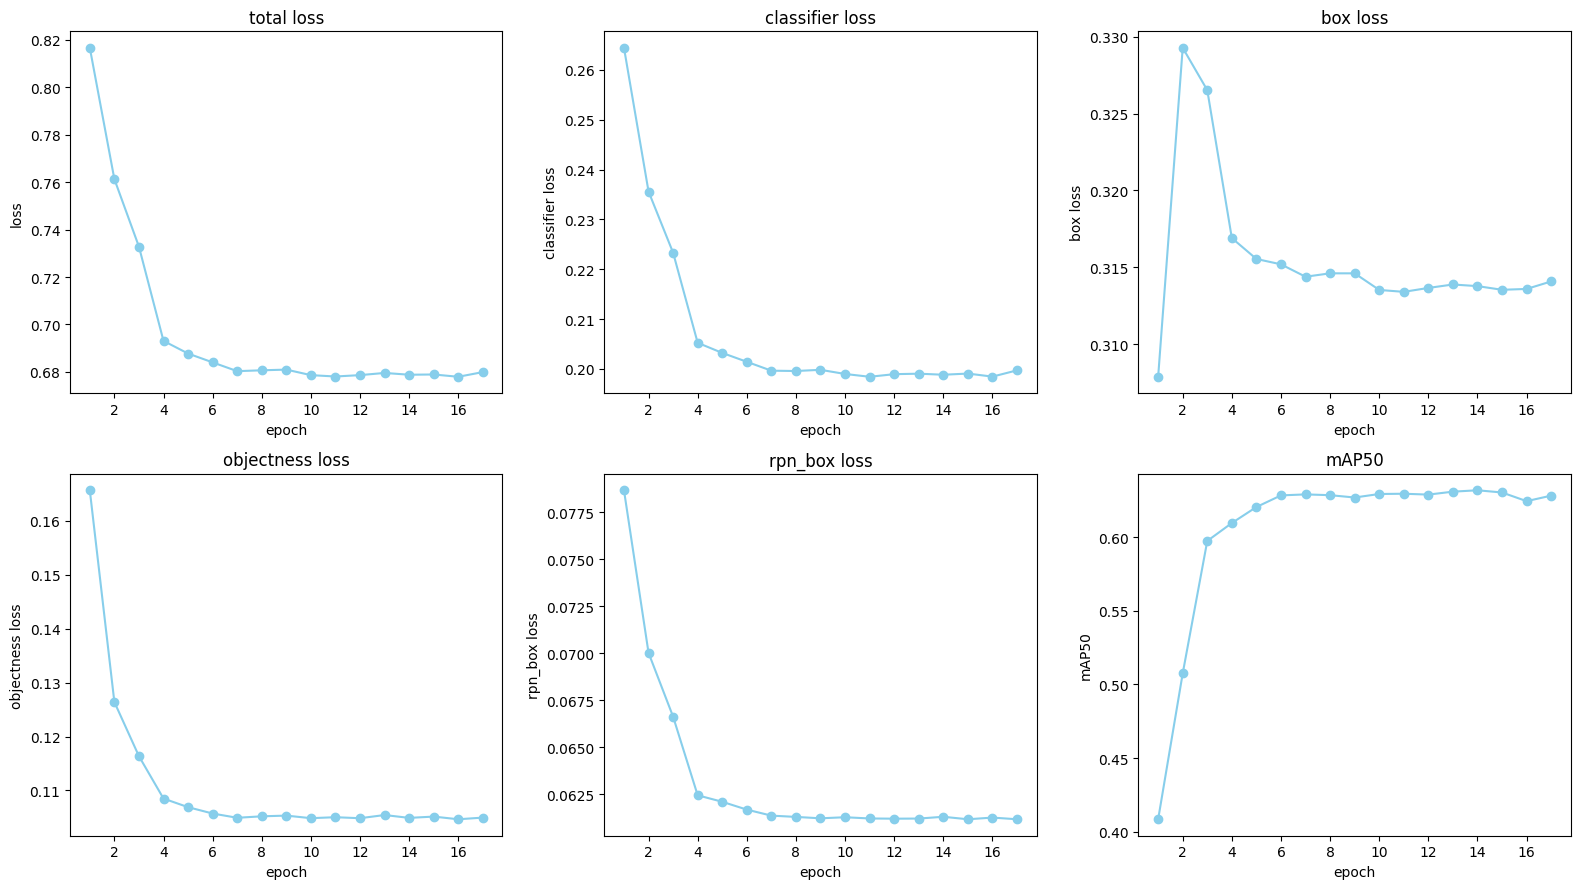

In [21]:
# Visualize loss và mAP
loss_mAP_curve(results)

# 6. Evaluation

In [22]:
def iou(boxes1, boxes2):
    """
    Tính IoU giữa tất cả các cặp boxes từ boxes1 và boxes2
    Args:
        boxes1 (torch.Tensor): shape (N, 4) - N boxes với format (x1, y1, x2, y2)
        boxes2 (torch.Tensor): shape (M, 4) - M boxes với format (x1, y1, x2, y2)
    Returns:
        torch.Tensor: shape (N, M) - ma trận IoU
    """
    # Tính area của boxes1
    area1 = (boxes1[:, 2] - boxes1[:, 0]) * (boxes1[:, 3] - boxes1[:, 1])  # shape: (N,)
    
    # Tính area của boxes2
    area2 = (boxes2[:, 2] - boxes2[:, 0]) * (boxes2[:, 3] - boxes2[:, 1])  # shape: (M,)
    
    # Mở rộng kích thước để broadcast
    # boxes1: (N, 1, 4), boxes2: (1, M, 4)
    boxes1 = boxes1[:, None, :]  # Thêm chiều mới ở giữa
    boxes2 = boxes2[None, :, :]  # Thêm chiều mới ở đầu
    
    # Tính tọa độ của phần giao nhau
    left_top = torch.maximum(boxes1[..., :2], boxes2[..., :2])  # shape: (N, M, 2)
    right_bottom = torch.minimum(boxes1[..., 2:], boxes2[..., 2:])  # shape: (N, M, 2)
    
    # Tính width và height của phần giao nhau
    wh = (right_bottom - left_top).clamp(min=0)  # shape: (N, M, 2)
    inter = wh[..., 0] * wh[..., 1]  # shape: (N, M)
    
    # Tính union
    union = area1[:, None] + area2[None, :] - inter
    
    # Tính IoU
    iou = inter / union.clamp(min=1e-6)
    
    return iou

In [23]:
from torchmetrics.detection import MeanAveragePrecision
from tqdm import tqdm
import torch

def validate(val_dataloader, model, num_class, iou_threshold, device):
    model = model.to(device)
    model.eval()
    
    # Khởi tạo các biến để tính precision và recall
    true_positives = 0
    false_positives = 0
    false_negatives = 0
    
    # Khởi tạo metric MAP
    metric = MeanAveragePrecision(
        iou_type="bbox",
        iou_thresholds=[iou_threshold],
        box_format="xyxy",
        class_metrics=True
    ).to(device)
    
    with torch.inference_mode():
        for batch, (images, targets) in tqdm(enumerate(val_dataloader), total=len(val_dataloader)):
            images = [image.to(device) for image in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            
            outputs = model(images)
            
            preds = [{
                "boxes": output["boxes"],
                "scores": output["scores"],
                "labels": output["labels"],
            } for output in outputs]
            
            gt = [{
                "boxes": target["boxes"],
                "labels": target["labels"],
            } for target in targets]
            
            metric.update(preds, gt)
            
            for pred, target in zip(preds, gt):
                pred_boxes = pred["boxes"]
                pred_scores = pred["scores"]
                pred_labels = pred["labels"]
                gt_boxes = target["boxes"]
                gt_labels = target["labels"]
                
                ious = iou(pred_boxes, gt_boxes)
                
                # Chuyển IoU thành mask bool và sau đó thành float để có thể dùng argmax
                matches = (ious > iou_threshold).float()
                
                for pred_idx in range(len(pred_boxes)):
                    if pred_scores[pred_idx] > 0.5:
                        if matches[pred_idx].any():
                            # Tìm gt_idx có IoU cao nhất với pred_idx
                            gt_idx = matches[pred_idx].argmax()
                            if pred_labels[pred_idx] == gt_labels[gt_idx]:
                                true_positives += 1
                            else:
                                false_positives += 1
                        else:
                            false_positives += 1
                
                # Đếm false negatives
                matched_gt = matches.sum(dim=0) > 0  # Chuyển về bool
                false_negatives += (~matched_gt).sum().item()
    
    # Tính toán kết quả MAP
    result = metric.compute()
    mAP50 = result["map_50"].item()
    mAP50_95 = result["map"].item()
    
    # Tính precision và recall
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    
    # Tính F1-score
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    return mAP50, mAP50_95, f1_score

In [24]:
mAP50, mAP50_95, f1_score = validate(val_dataloader=val_dataloader,
                                     model=model,
                                     num_class=num_classes-1,
                                     iou_threshold=0.5,
                                     device=device)
print(f"mAP@50: {mAP50:.4f}")
print(f"mAP@50-95: {mAP50_95:.4f}")
print(f"F1-score: {f1_score:.4f}")

100%|██████████| 259/259 [01:41<00:00,  2.55it/s]


mAP@50: 0.6283
mAP@50-95: 0.6283
F1-score: 0.6483
